In [14]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne, load_dataset


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import tensorflow as tf
import torch

"""assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")"""

"""import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense"""

'import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense'

In [15]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors


def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();



We have loaded the dataframes and modified the formats so that they are similar

In [16]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})


data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [17]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [18]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "illumination", "infrared", "light_level"])

In [19]:
data_sensors = rename_sensor(data_sensors)

In [20]:
data_sensors.shape

(193215, 9)

Missing Values

In [21]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2               616
humidity          798
o3             129341
pressure        32485
temperature       801
tvoc            32307
dtype: int64
Series([], dtype: float64)


In [22]:
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")  

KeyboardInterrupt: 

In [ ]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
o3    129341
dtype: int64


In [ ]:
sensors = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']

for sensor in sensors:
    check = data_sensors[data_sensors['location'] == sensor]
    print(sensor)
    print(check[check.columns[check.isnull().sum()>0]].isnull().sum())
    print()

testqc2090
_field
o3    29
dtype: int64

Computer_Room
_field
o3    31509
dtype: int64

Digital_Lab
_field
o3    30068
dtype: int64

Biblio_Filo
Series([], dtype: float64)

24e124128c147446
_field
o3    1324
dtype: int64

24e124128c147470
_field
o3    1344
dtype: int64

AudioLab
Series([], dtype: float64)

OpenLab_Main_Room
_field
o3    32084
dtype: int64

OpenLab_Laser_Room
_field
o3    43
dtype: int64

24e124725c461468
_field
o3    31638
dtype: int64

Classroom
_field
o3    1302
dtype: int64



Duplicates

In [ ]:
data_sensors.duplicated().sum()

0

# Recommender System

In [ ]:
data_sensors

_field,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
24656,testqc2090,25-07-2023,13:50,472.0,36.0,0.05,996.9,27.8,100.0
24657,testqc2090,25-07-2023,14:00,466.0,36.0,0.05,996.9,27.9,100.0
24658,testqc2090,25-07-2023,14:10,466.0,36.0,0.05,996.9,27.9,100.0
24659,testqc2090,25-07-2023,14:20,455.0,36.0,0.05,996.8,27.9,100.0
24660,testqc2090,25-07-2023,14:30,463.0,36.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...
219251,Classroom,30-03-2024,11:43,438.0,39.0,NaN,976.1,22.0,173.0
219252,Classroom,30-03-2024,11:53,427.0,38.5,NaN,976.2,22.3,180.0
219253,Classroom,30-03-2024,12:03,433.0,38.0,NaN,976.2,22.5,183.0
219254,Classroom,30-03-2024,12:13,426.0,38.0,NaN,976.2,22.7,184.0


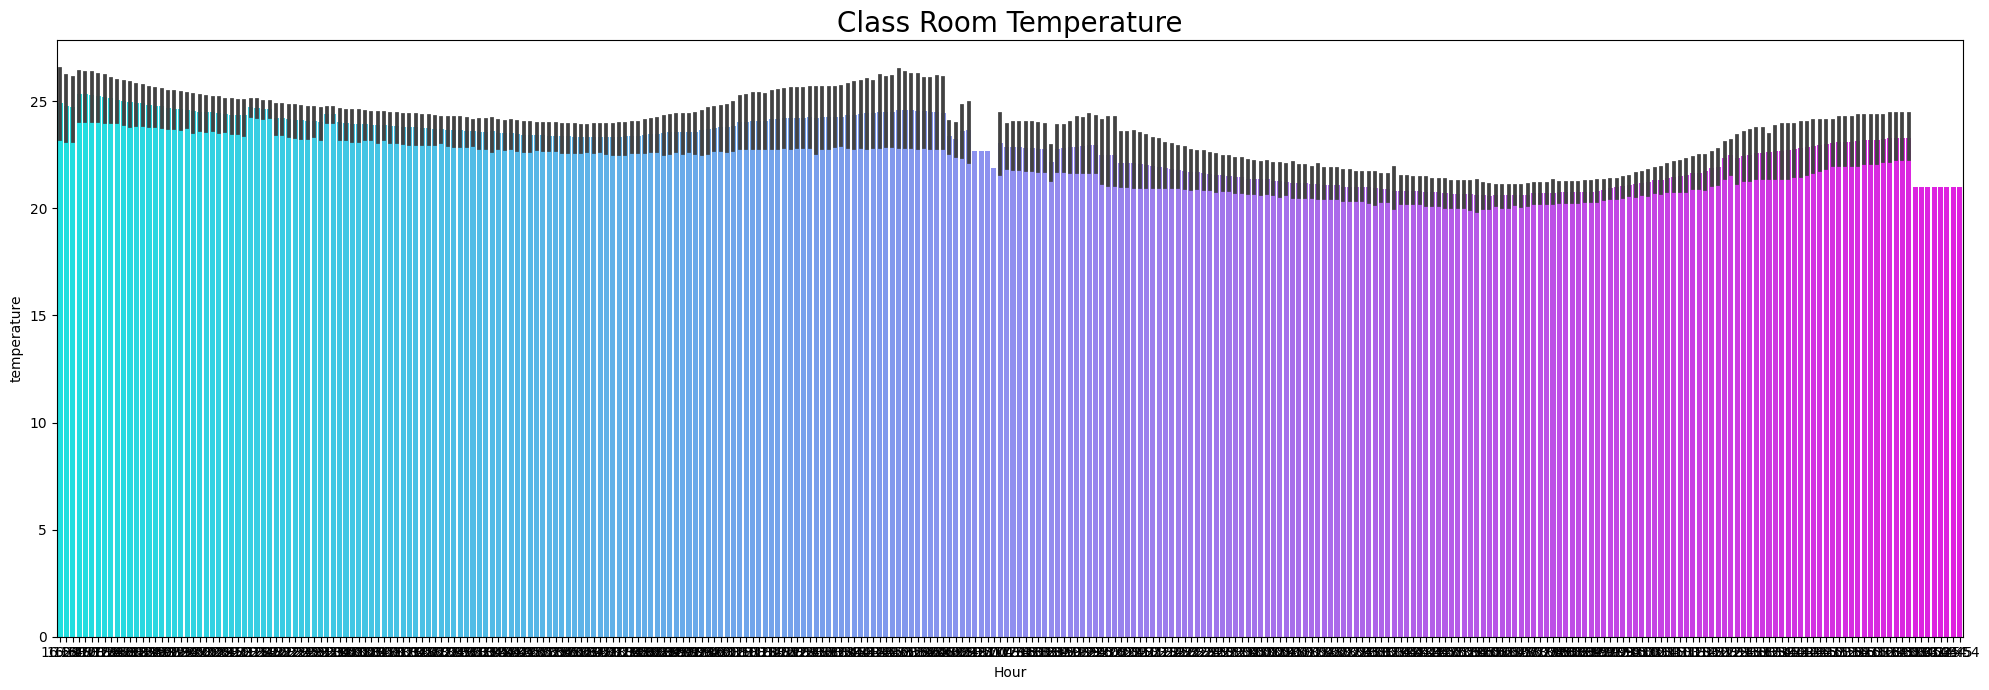

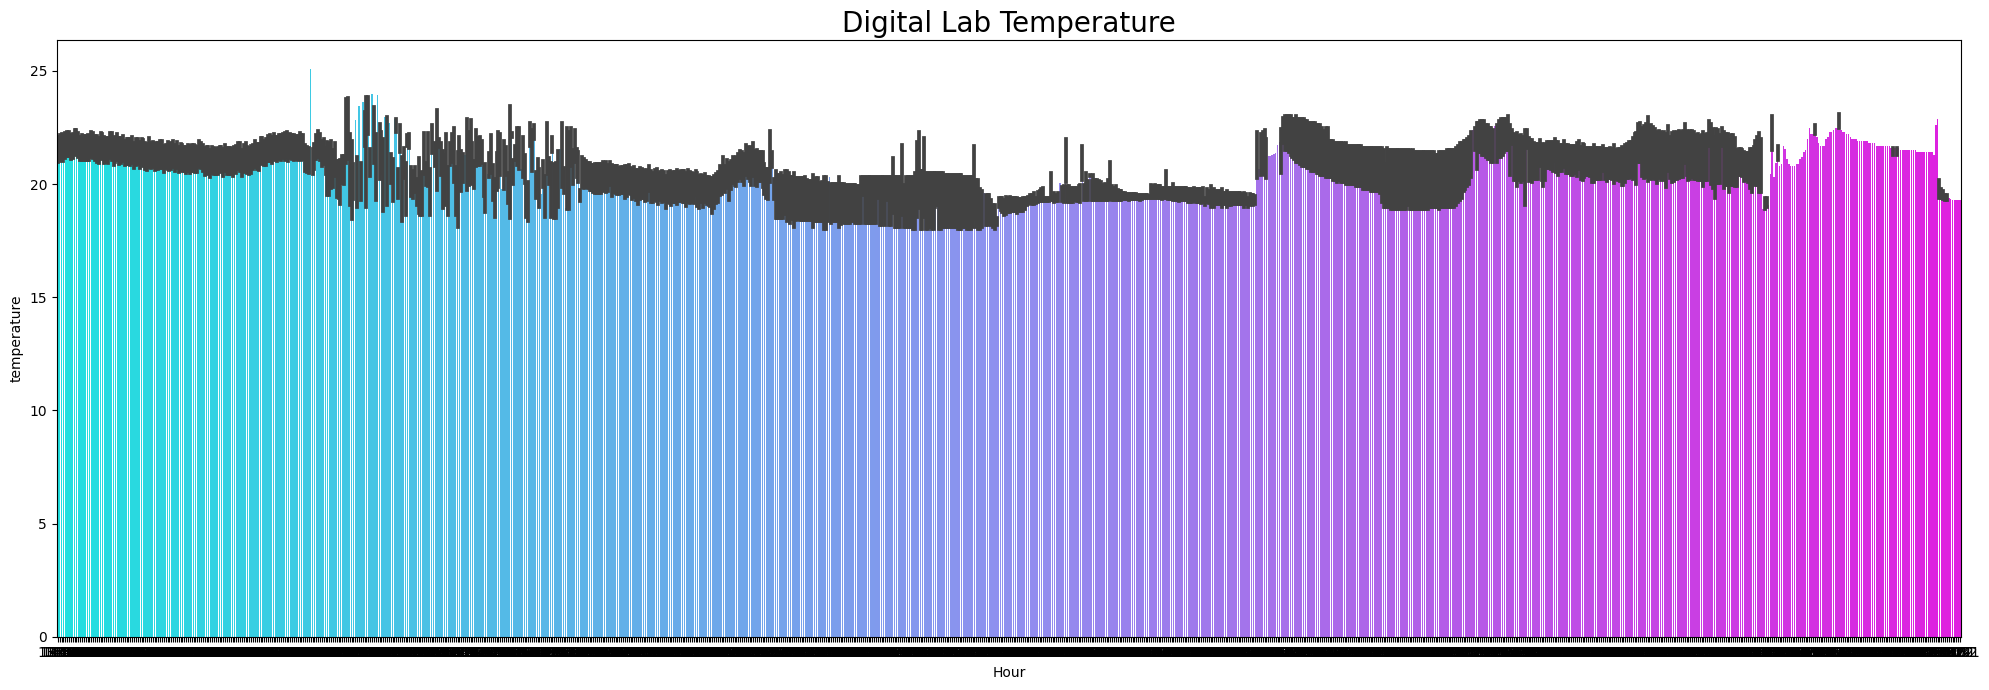

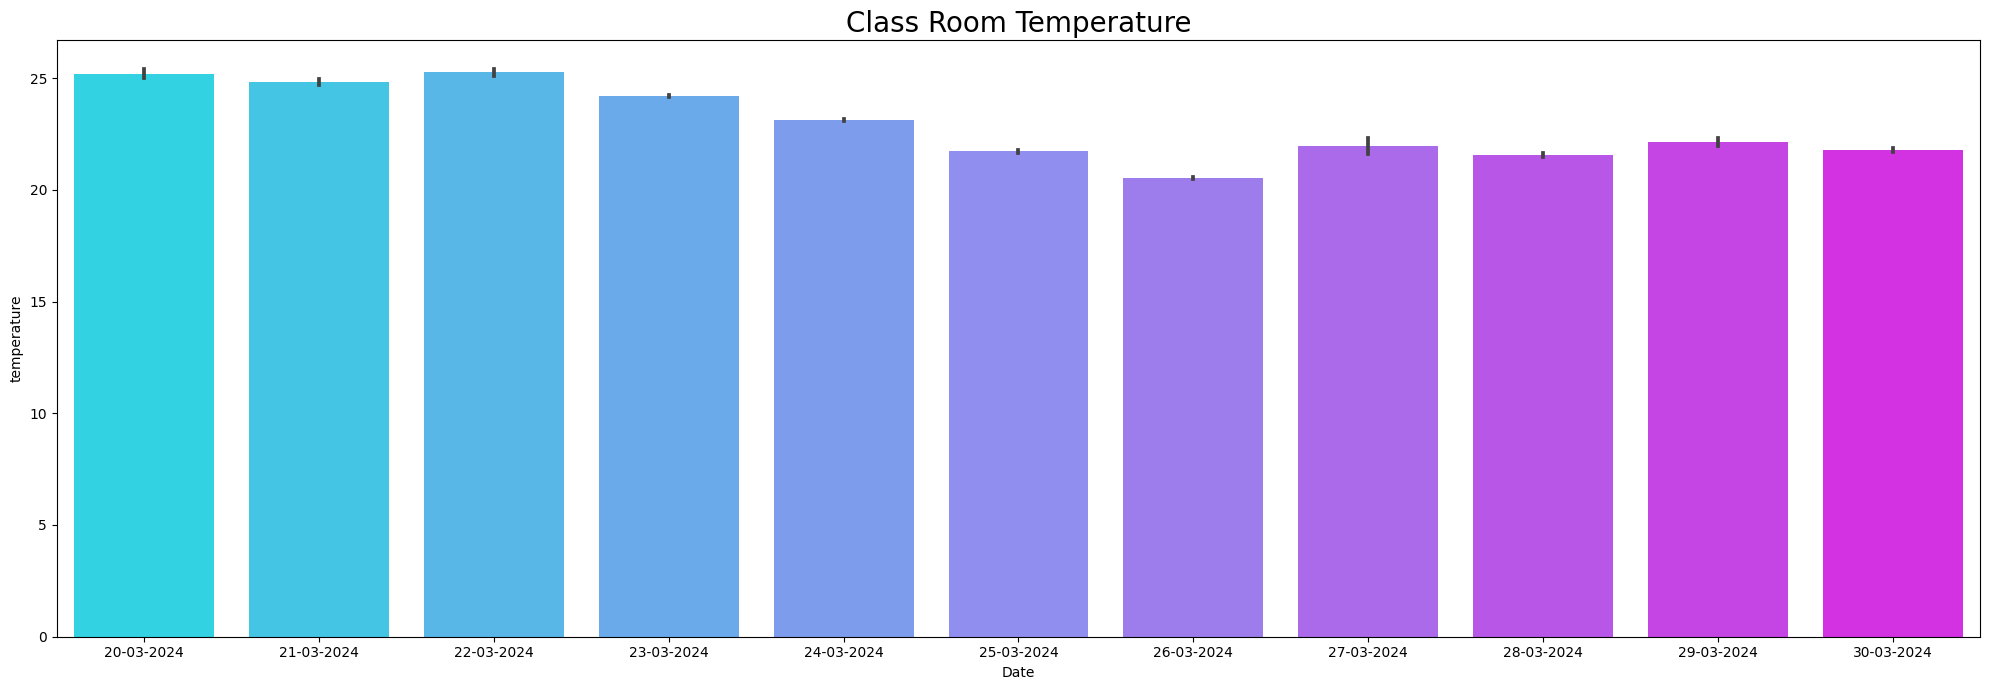

In [ ]:
Classroom = data_sensors[data_sensors['location'] == 'Classroom']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']

display_plot(Classroom, Classroom['Hour'], Classroom['temperature'], "Class Room Temperature")
display_plot(Digital_Lab, Digital_Lab['Hour'], Digital_Lab['temperature'], "Digital Lab Temperature")
display_plot(Classroom, Classroom['Date'], Classroom['temperature'], "Class Room Temperature")

C:\Users\migue\AppData\Local\Temp\ipykernel_24960\1010132178.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(Digital_Lab.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


<AxesSubplot:xlabel='_field', ylabel='_field'>

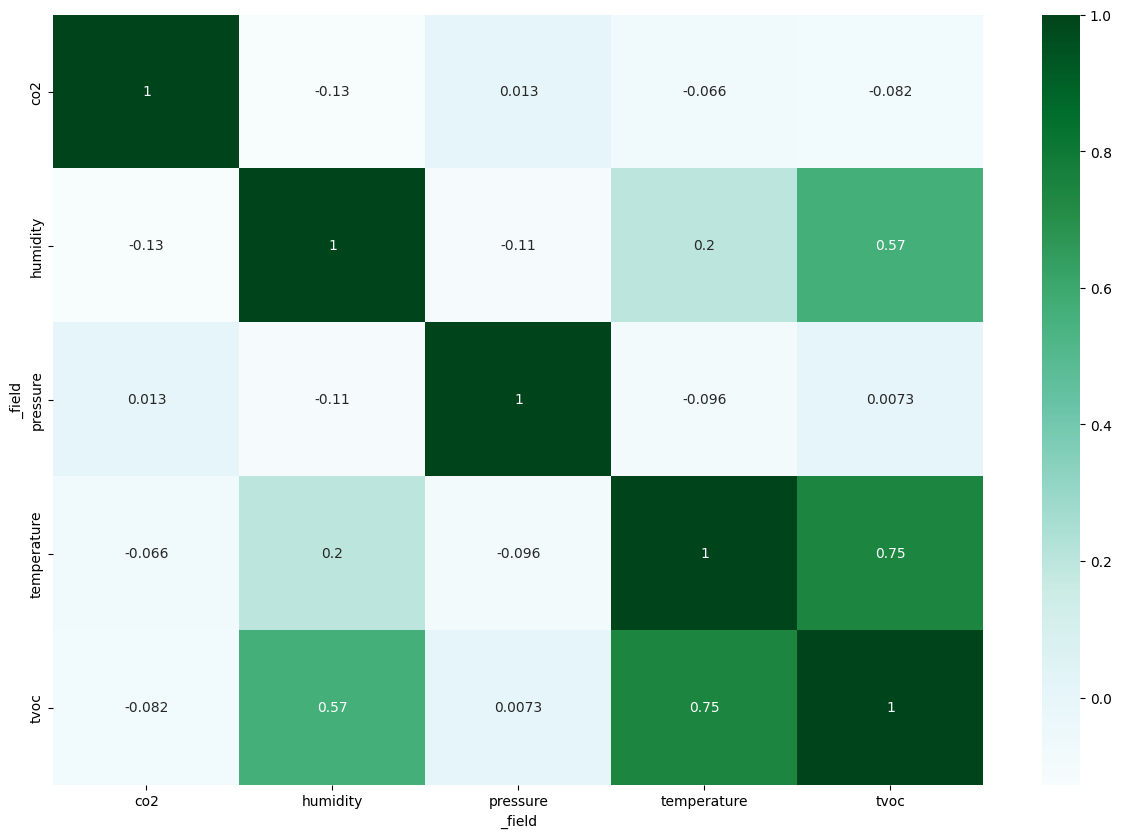

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(Digital_Lab.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


In [ ]:
Classroom

_field,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
217954,Classroom,20-03-2024,16:28,673.00,39.0,NaN,NaN,27.3,NaN
217955,Classroom,20-03-2024,16:38,629.50,39.5,NaN,NaN,26.6,NaN
217956,Classroom,20-03-2024,16:48,607.75,39.0,NaN,NaN,26.5,NaN
217957,Classroom,20-03-2024,16:58,596.88,39.0,NaN,NaN,26.5,NaN
217958,Classroom,20-03-2024,17:08,591.44,39.0,NaN,NaN,26.4,NaN
...,...,...,...,...,...,...,...,...,...
219251,Classroom,30-03-2024,11:43,438.00,39.0,NaN,976.1,22.0,173.0
219252,Classroom,30-03-2024,11:53,427.00,38.5,NaN,976.2,22.3,180.0
219253,Classroom,30-03-2024,12:03,433.00,38.0,NaN,976.2,22.5,183.0
219254,Classroom,30-03-2024,12:13,426.00,38.0,NaN,976.2,22.7,184.0
